In [1]:
library(reshape2)
library(lubridate)
library(tseries)
library(MASS,stats)
library(car)
library(fGarch)
library(rugarch)

Loading required package: timechange


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: carData

NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [2]:
data <- read.csv("SP500_e.csv")
head(data)

,caldt,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,20060103,0.016341,0.016340,0.015027,0.015023,11699545700,500,11540511600,500,1268.80,0.016430
2,20060104,0.003931,0.003736,0.006375,0.006284,11740829600,499,11697131300,499,1273.46,0.003673
3,20060105,0.000028,0.000021,0.000621,0.000611,11745619900,500,11745378700,500,1273.48,0.000016
4,20060106,0.009559,0.009322,0.010100,0.009988,11855262700,500,11745619900,500,1285.45,0.009399
5,20060109,0.003710,0.003708,0.005676,0.005673,11899300800,500,11855262700,500,1290.15,0.003656
6,20060110,-0.000340,-0.000394,0.000430,0.000379,11894617400,500,11899300800,500,1289.69,-0.000357


In [3]:
Ret <- data$sprtrn
y  <- as.matrix(Ret)
dates <- ymd(data$caldt)

In [4]:
n <- dim(y)[1]
# Initializing the EWMA matrix
EWMA <- matrix(NA, nrow = n, ncol = 3)
# Determine lambda
lambda <- 0.94

In [5]:
S <- cov(y)
S

0.000149603


In [6]:
# Fill the initial row of EWMA with the sample covariances
EWMA[1,] <- S[upper.tri(S, diag = TRUE)]

# Manually computing EWMA elements for t = 2

# Apply the formula for EWMA
S_2 <- lambda * S + (1-lambda) * y[1,] %*% t(y[1,])
# Get the variances and covariances
S_2[upper.tri(S_2, diag = TRUE)]

# Populating the EWMA matrix

# Create a loop for rows 2 to n
for (i in 2:n) {
    # Update S with the new weighted moving average
    S <- lambda * S + (1-lambda) * y[i-1,] %*% t(y[i-1,])
    
    # Fill the following EWMA row with the covariances
    EWMA[i,] <- S[upper.tri(S, diag = TRUE)]
}

head(EWMA)

[1] 0.0001568235

0.0001496030,0.0001496030,0.0001496030
0.0001568235,0.0001568235,0.0001568235
0.0001482235,0.0001482235,0.0001482235
0.0001393301,0.0001393301,0.0001393301
0.0001362708,0.0001362708,0.0001362708
0.0001288965,0.0001288965,0.0001288965


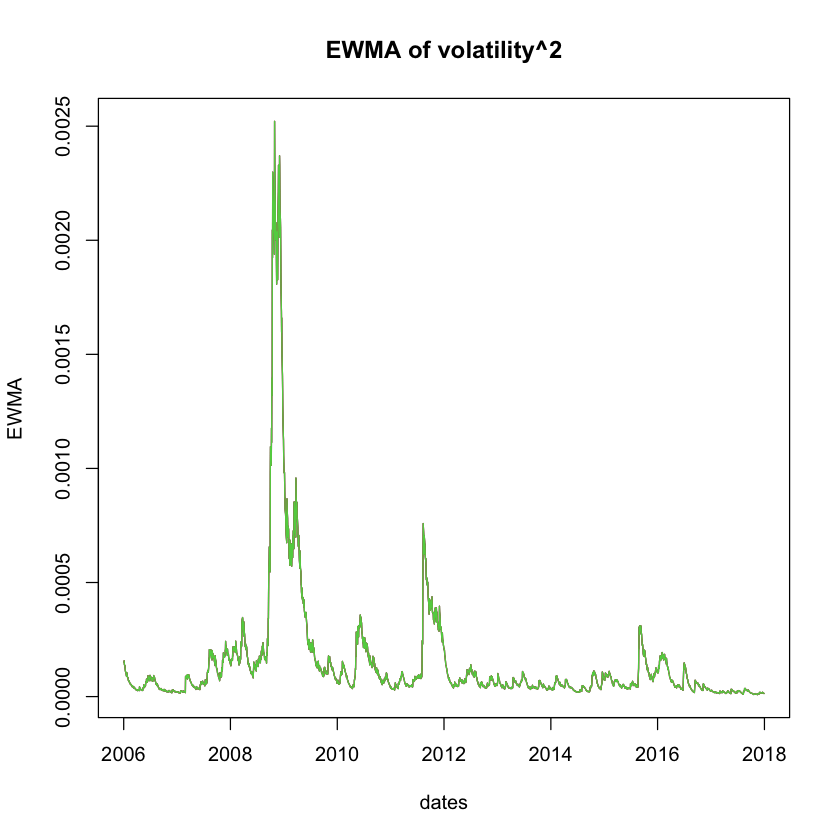

In [7]:
# Plotting estimated variances and covariances
matplot(dates, EWMA, type = "l", main = "EWMA of volatility^2", lty = 1)

In [8]:
# Implementing EWMA VaR

# Specifying the parameters for VaR
p <- 0.05
portfolio_value <- 1000

# Specifying the parameters for EWMA
lambda <- 0.94
n <- length(y)
BurnTime <- 30

# Vector to store estimated conditional volatility
EWMA_Variance <- rep(NA, length = n)

# First value is the sample variance
EWMA_Variance[1] <- var(y)

# See the vector
head(EWMA_Variance)

[1] 0.000149603          NA          NA          NA          NA          NA

In [9]:
# Run the EWMA model using a for loop
for (i in 2:n) {
    EWMA_Variance[i] <- lambda * EWMA_Variance[i-1] + (1-lambda) * y[i-1]^2
}

In [10]:
# Replacing the data in the estimation window to NA
EWMA_Variance[1:BurnTime] <- NA

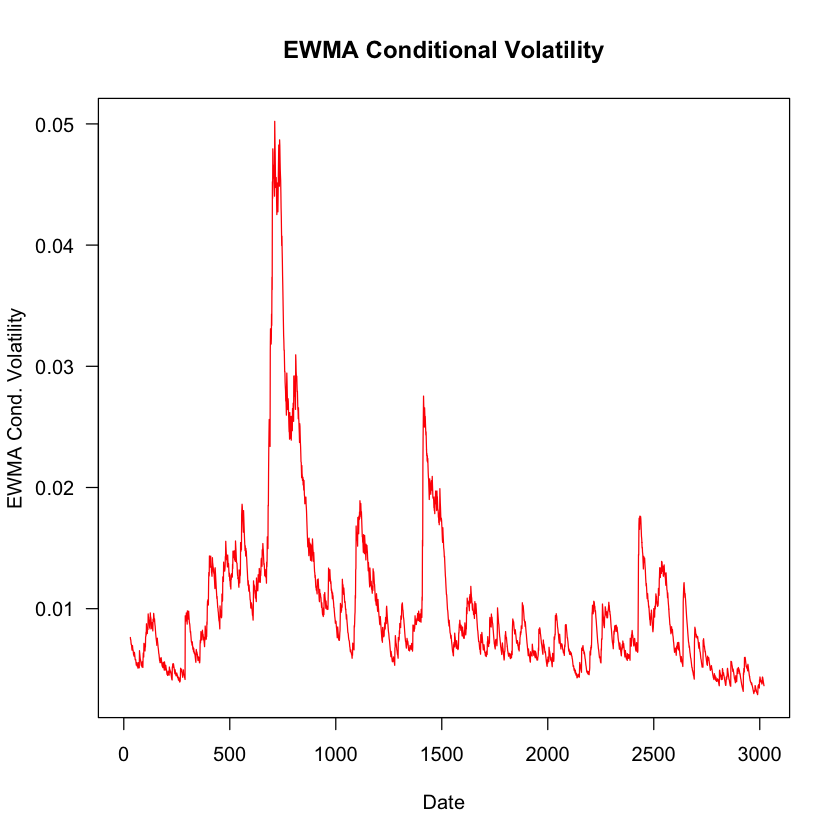

In [11]:
# Plot estimation for conditional volatility
EWMA_cond_volatility <- sqrt(EWMA_Variance)
plot(EWMA_cond_volatility, type = "l", main = "EWMA Conditional Volatility",
    las = 1, col = "red", xlab = "Date", ylab = "EWMA Cond. Volatility")

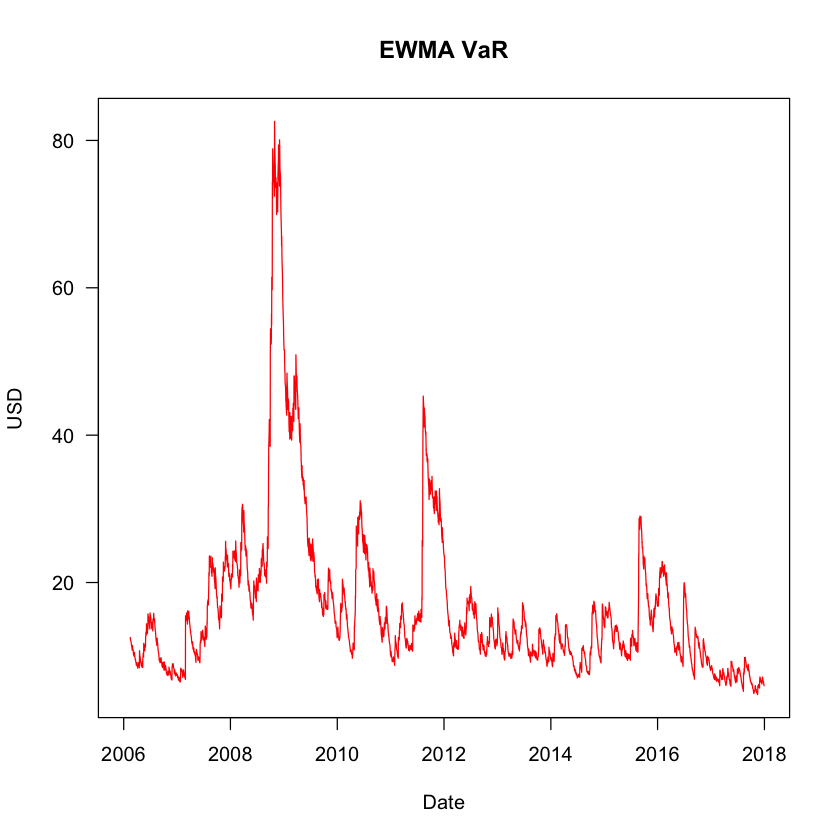

In [12]:
# Implementing the VaR forecast
EWMA_VaR <- -qnorm(p) * EWMA_cond_volatility * portfolio_value

# Plotting it
plot(dates, EWMA_VaR, type = "l", main = "EWMA VaR",
    las = 1, col = "red", xlab = "Date", ylab = "USD")

In [13]:
print(EWMA_VaR)

   [1]        NA        NA        NA        NA        NA        NA        NA
   [8]        NA        NA        NA        NA        NA        NA        NA
  [15]        NA        NA        NA        NA        NA        NA        NA
  [22]        NA        NA        NA        NA        NA        NA        NA
  [29]        NA        NA 12.541061 12.240696 12.229545 11.875832 11.589224
  [36] 11.636770 11.384326 11.049443 10.812589 11.289757 11.440688 11.111489
  [43] 10.789523 10.831007 10.527815 10.239812 10.120769 10.249458  9.969512
  [50] 10.534329 10.357295 10.067146  9.778438  9.504110  9.527940  9.550901
  [57]  9.318194  9.043002  8.777293  8.896447  9.135440  8.894673  8.785692
  [64]  8.568346  8.681411  8.594288  8.368341  9.121038  8.849788  9.128775
  [71]  8.863982  8.599635  8.421379 10.752430 10.448522 10.141142  9.832357
  [78]  9.582435  9.495457  9.275985  9.091271  8.818571  8.710727  8.800796
  [85]  8.689745  8.533347  9.254949  8.979235  8.706913  8.470327  9.696902

In [14]:
print(sqrt(var(Ret)))

[1] 0.01223123


## GARCH

In [15]:
data <- read.csv("SP500_e.csv")
head(data)

Ret <- data$sprtrn
y  <- as.matrix(Ret)
dates <- ymd(data$caldt)

# Parameters
portfolio_value = 1000
p = 0.05 #probability for VaR
probability = p

,caldt,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,20060103,0.016341,0.016340,0.015027,0.015023,11699545700,500,11540511600,500,1268.80,0.016430
2,20060104,0.003931,0.003736,0.006375,0.006284,11740829600,499,11697131300,499,1273.46,0.003673
3,20060105,0.000028,0.000021,0.000621,0.000611,11745619900,500,11745378700,500,1273.48,0.000016
4,20060106,0.009559,0.009322,0.010100,0.009988,11855262700,500,11745619900,500,1285.45,0.009399
5,20060109,0.003710,0.003708,0.005676,0.005673,11899300800,500,11855262700,500,1290.15,0.003656
6,20060110,-0.000340,-0.000394,0.000430,0.000379,11894617400,500,11899300800,500,1289.69,-0.000357


In [16]:
# Steps inside the function:
# Take as argument
# GARCH spec, here the default
# Probability, here 0.05
# Portfolio value, here 1000
# Estimation window, here 1000
spec <- ugarchspec()
p <- 0.05
portfolio_value <- 1000
WE <- 1000

# Determine number of observations
n <- length(y)

# Initialize empty VaR vector
    
VaR <- rep(NA, n)
    
# Do a loop for the forecast
for (i in 1:(n-WE)){
        
    # Subset the dataset to the estimation window
    window <- y[i:(i+WE-1)]
        
    # Fit the GARCH
    res <- ugarchfit(spec = spec, data = window, solver = "hybrid")
        
    # Save coefficients
    omega <- coef(res)['omega']
    alpha <- coef(res)['alpha1']
    beta <- coef(res)['beta1']
        
    # Estimate sigma2 using the last observation of window
    sigma2 <- omega + alpha*tail(window,1)^2 + beta*tail(res@fit$var,1)
        
    # Allocate the VaR forecast in the vector
    VaR[i+WE] <- -sqrt(sigma2) * qnorm(probability) * portfolio_value
    }

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mea

In [17]:
# Function that creates a GARCH forecast

DoGARCH <- function(y, spec, probability = p, portfolio_value = 1, WE = 1000){
    # GARCH function that takes as argument:
    # y: A vector of returns, ordered by date
    # spec: The ugarchspec object with the GARCH specification
    # probability: The probability to be used for VaR - Default 5%
    # portfolio_value: The portfolio value - Default 1
    # WE: Estimation window for the forecast - Default 1000 days
    
    # To calculate elapsed time, first get the current time
    old <- Sys.time()
    
    # Print message
    cat("Doing GARCH VaR forecast", "\n",
       "Estimation window:", WE, "\n",
       "Number of observations:", length(y), "\n",
       "VaR probability:", probability, "\n",
       "Portfolio value:", portfolio_value)
    
    # Number of observations
    n <- length(y)
    
    # Initialize empty VaR vector
    VaR <- rep(NA, n)
    
    # Do a loop for the forecast
    for (i in 1:(n-WE)){
        
        # Subset the dataset to the estimation window
        window <- y[i:(i+WE-1)]
        
        # Fit the GARCH
        res <- ugarchfit(spec = spec, data = window, solver = "hybrid")
        
        # Save coefficients
        omega <- coef(res)['omega']
        alpha <- coef(res)['alpha1']
        beta <- coef(res)['beta1']
        
        # Estimate sigma2 using the last observation of window
        sigma2 <- omega + alpha*tail(window,1)^2 + beta*tail(res@fit$var,1)
        
        # Allocate the VaR forecast in the vector
        VaR[i+WE] <- -sqrt(sigma2) * qnorm(probability) * portfolio_value
    }
    
    # Get the new time and print the elapsed time
    time <- difftime(Sys.time(), old, units = "secs")
    cat("\n", "Elapsed time:", round(time,4), "seconds")
    
    # Return the VaR vector
    return(VaR)
}

In [18]:
# Create specification
spec <- ugarchspec(
  variance.model = list(garchOrder= c(1,1)),
  mean.model = list(armaOrder = c(0,0), include.mean=FALSE)
)

In [19]:
# GARCH VaR for 200 days
GARCH200 <- DoGARCH(y, spec = spec, probability = p, portfolio_value = 1000, WE = 200)

Doing GARCH VaR forecast 
 Estimation window: 200 
 Number of observations: 3020 
 VaR probability: 0.05 
 Portfolio value: 1000
 Elapsed time: 138.6633 seconds

In [20]:
# GARCH VaR for 150 days
GARCH150 <- DoGARCH(y, spec = spec, probability = p, portfolio_value = 1000, WE = 150)

Doing GARCH VaR forecast 
 Estimation window: 150 
 Number of observations: 3020 
 VaR probability: 0.05 
 Portfolio value: 1000
 Elapsed time: 132.9624 seconds

In [21]:
# GARCH VaR for 100 days
GARCH100 <- DoGARCH(y, spec = spec, probability = p, portfolio_value = 1000, WE = 100)

Doing GARCH VaR forecast 
 Estimation window: 100 
 Number of observations: 3020 
 VaR probability: 0.05 
 Portfolio value: 1000
 Elapsed time: 133.0447 seconds

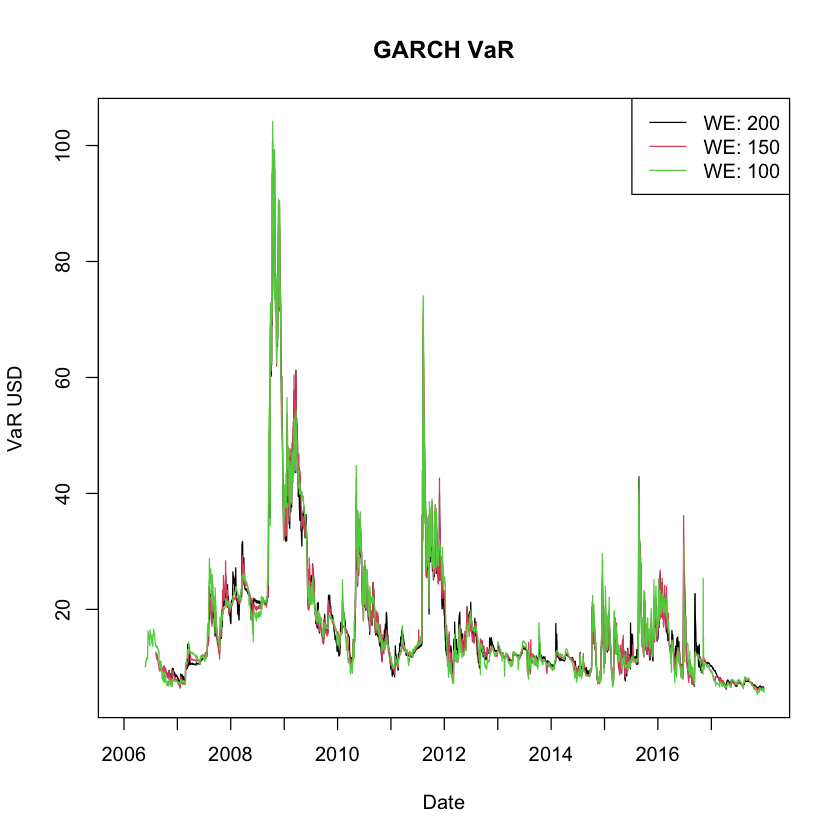

In [22]:
# Bind into a matrix
GARCH_VaR <- cbind(GARCH200, GARCH150, GARCH100)

# Plot and modify axis to include dates
matplot(dates, GARCH_VaR, type = "l", lty = 1, col = 1:3, xaxt = "n", main = "GARCH VaR", xlab = "Date", ylab = "VaR USD")
axis.Date(1, at = seq(min(dates), max(dates), by = "years"))

# Legend
legend("topright", legend = c("WE: 200", "WE: 150", "WE: 100"), lty = 1, col = 1:3)

In [23]:
VaR <- cbind(EWMA_VaR)

In [24]:
# Combining all VaR forecasts
# VaR is load from .RData file includes VaR for HS300, HS1000, HS2000 and EWMA
VaR <- cbind(VaR, GARCH200, GARCH150, GARCH100)

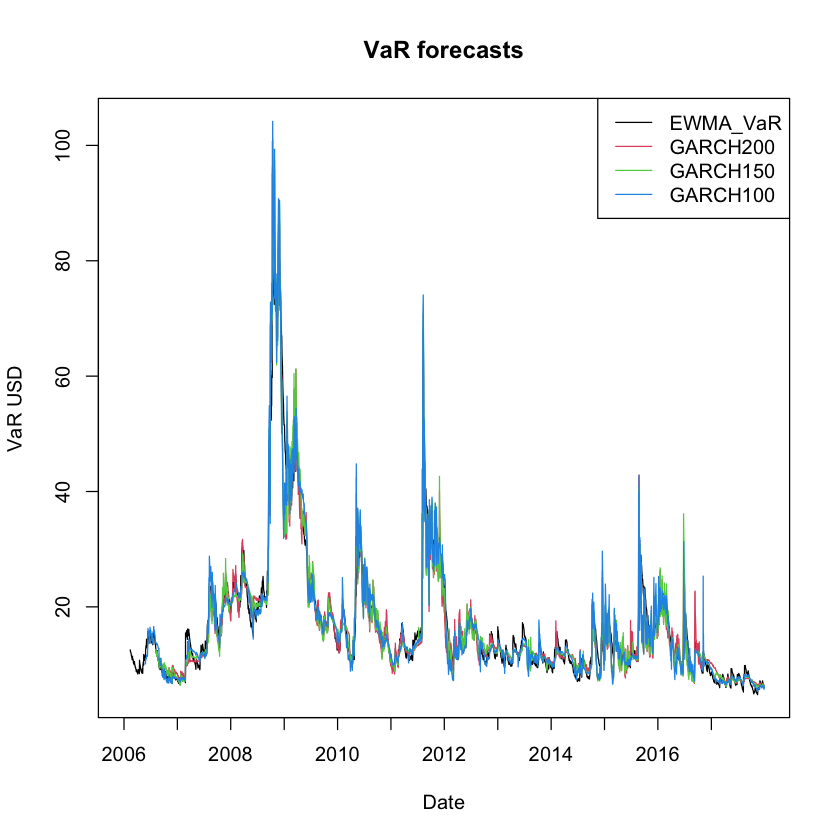

In [25]:
# Plot all
matplot(dates, VaR, type = "l", lty = 1, col = 1:6, xaxt = "n", main = "VaR forecasts", xlab = "Date", ylab = "VaR USD")
axis.Date(1, at = seq(min(dates), max(dates), by = "years"))

# Legend
legend("topright", legend = colnames(VaR), lty = 1, col = 1:6)

## backtesting

In [26]:
# Means for each forecast
round(colMeans(VaR, na.rm = TRUE),3)

# Standard deviations - We
round(apply(VaR, MARGIN = 2, sd, na.rm = TRUE))

EWMA_VaR GARCH200 GARCH150 GARCH100 
  16.744   17.055   16.937   16.961

EWMA_VaR GARCH200 GARCH150 GARCH100 
      11       12       12       12

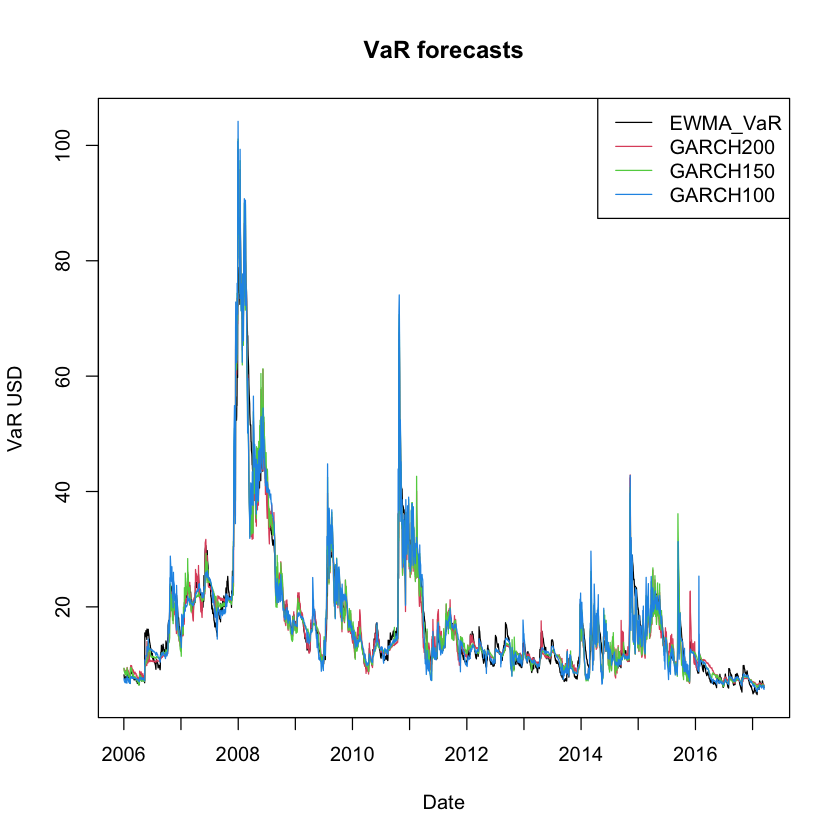

In [27]:
# Find maximum estimation window
windows <- colSums(is.na(VaR))

#restrict to largest estimation window
start <- max(windows) + 1
end <- length(dates)

# Plot all
matplot(dates[start:end], VaR[start:end,], type = "l", lty = 1, col = 1:6, xaxt = "n",
        main = "VaR forecasts", xlab = "Date", ylab = "VaR USD")
axis.Date(1, at = seq(dates[max(windows)], max(dates), by = "years"))

# Legend
legend("topright", legend = colnames(VaR), lty = 1, col = 1:6)

In [28]:
# Backtesting and Violation Ratios

# Let's transform VaR to a data.frame
VaR <- as.data.frame(VaR)

# Initialize a Violations data.frame, same dim and colnames as VaR, fill with NA
Violations <- VaR
Violations[] <- NA

dim(Violations)

[1] 3020    4

In [29]:
# Populating the Violations matrix

# For every model (columns in VaR) restricted to largest estimation window
for(i in 1:dim(VaR)[2]){
    
    # Fill the column in Violations with TRUE/FALSE
    # TRUE if the realized return is lower than VaR
    # FALSE otherwise
    Violations[,i] <- (y*portfolio_value < -VaR[,i])
}

# Restrict to largest estimation window
Violations[1:(start-1),] <- NA

In [30]:
# Find where violations happened
dates[which(Violations$EWMA_VaR)]

[1] "2006-10-27" "2006-11-27" "2007-01-25" "2007-02-27" "2007-03-13"
  [6] "2007-05-10" "2007-05-24" "2007-06-07" "2007-06-20" "2007-06-22"
 [11] "2007-07-10" "2007-07-24" "2007-07-26" "2007-08-03" "2007-08-09"
 [16] "2007-08-28" "2007-10-19" "2007-11-01" "2007-11-07" "2007-11-26"
 [21] "2007-12-11" "2008-01-04" "2008-01-15" "2008-01-17" "2008-02-05"
 [26] "2008-02-29" "2008-03-06" "2008-06-06" "2008-06-20" "2008-06-26"
 [31] "2008-07-09" "2008-07-24" "2008-09-04" "2008-09-09" "2008-09-15"
 [36] "2008-09-17" "2008-09-29" "2008-10-07" "2008-10-09" "2008-10-15"
 [41] "2008-12-01" "2009-01-20" "2009-02-10" "2009-02-17" "2009-03-02"
 [46] "2009-03-05" "2009-04-20" "2009-06-22" "2009-07-02" "2009-08-17"
 [51] "2009-09-01" "2009-10-01" "2009-10-28" "2009-10-30" "2010-01-21"
 [56] "2010-01-22" "2010-02-04" "2010-04-16" "2010-04-27" "2010-04-30"
 [61] "2010-05-04" "2010-05-06" "2010-05-20" "2010-06-04" "2010-06-29"
 [66] "2010-07-16" "2010-08-11" "2010-10-19" "2010-11-16" "2010-11-23"
 [71] "2011-01-19" "2011-01-28" "2011-02-22" "2011-03-01" "2011-03-10"
 [76] "2011-03-16" "2011-05-11" "2011-05-23" "2011-06-01" "2011-06-10"
 [81] "2011-06-15" "2011-07-11" "2011-07-27" "2011-08-02" "2011-08-04"
 [86] "2011-08-08" "2011-08-10" "2011-08-18" "2011-11-09" "2012-03-06"
 [91] "2012-04-09" "2012-04-10" "2012-05-04" "2012-05-17" "2012-05-30"
 [96] "2012-06-01" "2012-06-21" "2012-10-19" "2012-10-23" "2012-11-07"
[101] "2013-02-04" "2013-02-20" "2013-02-25" "2013-04-03" "2013-04-15"
[106] "2013-05-31" "2013-06-05" "2013-06-19" "2013-06-20" "2013-08-15"
[111] "2013-08-27" "2013-10-08" "2013-11-07" "2013-12-11" "2014-01-13"
[116] "2014-01-24" "2014-02-03" "2014-03-13" "2014-04-04" "2014-04-10"
[121] "2014-07-17" "2014-07-31" "2014-09-22" "2014-09-25" "2014-10-01"
[126] "2014-10-07" "2014-10-09" "2014-10-13" "2014-12-10" "2014-12-12"
[131] "2015-01-05" "2015-03-06" "2015-03-10" "2015-03-25" "2015-04-17"
[136] "2015-04-30" "2015-05-05" "2015-05-26" "2015-06-29" "2015-07-08"
[141] "2015-08-20" "2015-08-21" "2015-08-24" "2015-09-01" "2015-09-28"
[146] "2015-12-03" "2015-12-11" "2015-12-18" "2016-01-07" "2016-01-13"
[151] "2016-01-15" "2016-06-24" "2016-06-27" "2016-09-09" "2016-09-13"
[156] "2016-10-11" "2016-12-28" "2017-03-21" "2017-04-13" "2017-05-17"
[161] "2017-06-27" "2017-06-29" "2017-07-06" "2017-08-10" "2017-08-17"
[166] "2017-11-15"

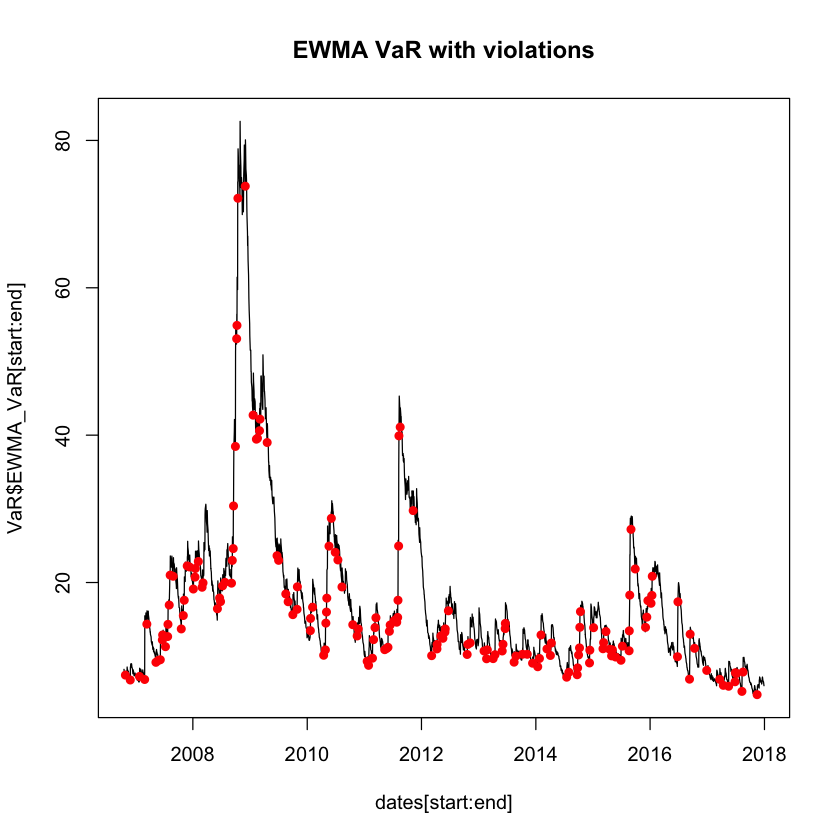

In [31]:
# Plotting the violations
plot(dates[start:end], VaR$EWMA_VaR[start:end], type = "l", main = "EWMA VaR with violations",)

# Add points where the violations happened
points(dates[Violations$EWMA_VaR], VaR$EWMA_VaR[Violations$EWMA_VaR], pch = 16, col = "red")

In [32]:
# Check dates where all models have a violation
# restrict to largest estimation window
w <- apply(Violations, 1, all)

In [33]:
# Days where all models have a violation
# na.rm =TRUE means we will firstly remove all NA elements
sum(w, na.rm = TRUE)

[1] 139

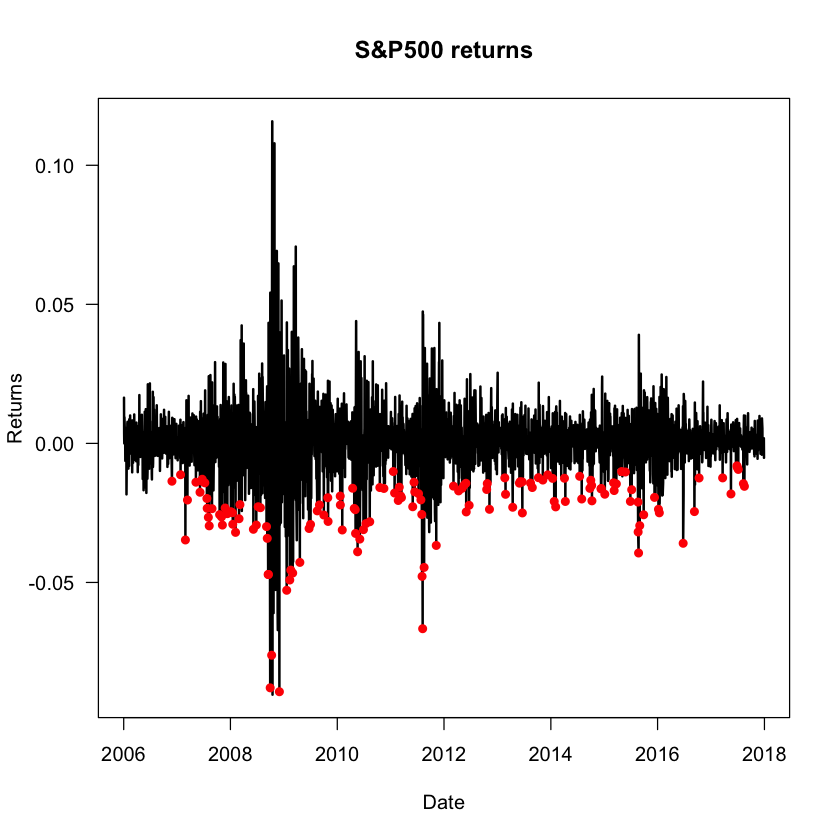

In [34]:
# Plotting the returns and adding the days where all models had a violation
plot(dates, y, main = "S&P500 returns", type = "l", lwd = 2, las = 1,
    xlab = "Date", ylab = "Returns")
points(dates[w], y[w], pch = 16, col = "red")

In [35]:
# Counting Violations by model
colSums(Violations, na.rm = TRUE)

EWMA_VaR GARCH200 GARCH150 GARCH100 
     166      159      164      163

In [36]:
# Creating a Violation Ratio object

# Remove the rows with NA
Violations <- Violations[!is.na(Violations[,2]),]

# Get the column sums
V <- colSums(Violations)

# Calculate expected violations
EV <- dim(Violations)[1]*p

# Violation Ratios
VR <- V/EV

# Call object, rounding to 3 decimals
round(VR,3)

EWMA_VaR GARCH200 GARCH150 GARCH100 
   1.177    1.128    1.163    1.156

In [37]:
# We can write a function that uses our rule of thumb to assess the model
model_assessment <- function(VR) {
    if (VR > 0.8 & VR < 1.2) {
        paste0(names(VR), "Model is good")
    } else if ((VR > 0.5 & VR <= 0.8) | (VR > 1.2 & VR <= 1.5)) {
        paste0(names(VR), "Model is acceptable")
    } else if ((VR > 0.3 & VR <= 0.5) | (VR > 1.5 & VR <= 2)) {
        paste0(names(VR), "Model is bad")
    } else {
        paste0(names(VR), "Model is useless")
    }
}

In [38]:
# We can use sapply(), the vector version of apply()
sapply(VR, model_assessment)

EWMA_VaR        GARCH200        GARCH150        GARCH100 
"Model is good" "Model is good" "Model is good" "Model is good"

In [39]:
# Best performing - VR closest to 1
sort(round(abs(VR-1),3))

GARCH200 GARCH100 GARCH150 EWMA_VaR 
   0.128    0.156    0.163    0.177